# MODEL TRAINING  USING THE TF OBJECT DETECTION API

This notebook is based on modular [shell scripts](./scripts) for convenience. The scripts comprise minimal lines of code (LOC), on average, no more than 10 LOC for each, making them easy to read, learn, and adapt for future applications.

**!!!Caveat :** 

Some scripts can be conveniently executed directly from this notebook, and some need to be executed in terminal to grant permissions. I recommend running each script from the terminal to see STDOUT clearly. If run in terminal, use the [module-training](./) directory as the working directory.

***This is an academic project. Interested developers are invited to freely contribute issues, questions, improvements, and discussions.***

## 1. CHECK SUBMODULES

[`check-submodules.sh`](./scripts/) makes sure that the [LabelImg](https://github.com/tzutalin/labelImg) and [TF models](https://github.com/tensorflow/models) submodule repositories are initialized correctly.

In [1]:
!./scripts/check-submodules.sh

-- checking submodules


## 2. CREATE VIRTUAL ENVIRONMENT

[`venv.sh`](./scripts/) creates a virtual environment and installs essential [apt](./resources/apt.txt) and [pip](./resources/pip.txt) dependencies into the environment. As such, the script should be executed in terminal to grant install permissions [( see dependencies.sh )](./scripts/). By default, the name of the virtual environment is **tfod-venv**. This name can, of cause, be changed. From working directory run `./scripts/venv.sh`

## 3. INSTALL TF OBJECT DETECTION

This command can also be run in terminal to leverage clear STDOUT, which is critical to verify correct installation.

In [ ]:
!./scripts/tfod.sh

## 4. GET PRETRAINED MODEL FROM [TENSOR FLOW MODEL ZOO](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md)

[`pretrained-model.sh`](./scripts/) uses *wget* to download a pre-trained model from the [zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). The script can be adapted to download any pre-trained model. From terminal run `/scripts/pretrained-model.sh`

<hr style=\"border:2px solid gray\"> </hr>

**!!!CAVEAT :** 

Before proceeding, verify [tallying versions](https://www.tensorflow.org/install/source#gpu) of tensorflow, tensorflow-gpu, cuDNN, and CUDA have been installed. [The CUDA Toolkit](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html#download-nvidia-driver-and-cuda-software) a good place to start. You may need to purge any existing versions of CUDA on your system. Also remember to link CUDA after after a fresh install. A quick way to check currently installed versions is using: 

`sudo find / -name 'libcudart.so*'`

`sudo find / -name 'libcudnn.so*'`

Once **correct** libraries are found, export the corresponding paths:

`export PATH=/usr/lib/x86_64-linux-gnu${PATH:+:${PATH}}`

`export LD_LIBRARY_PATH=/usr/lib/x86_64-linux-gnu:${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}`

After exporting, grant remeber to permissions:

`sudo chmod a+r /usr/lib/x86_64-linux-gnu/libcuda*`

`sudo chmod a+r /usr/lib/x86_64-linux-gnu/libcudnn*`

*** N.b., the above commands serve only as a guideline. Simply put—copy-paste wont cut it here! Run through the commands and ensure tallying CUDA and cuDNN versions are installed. There after, link the dynamic libraries (as illustrated iff using Ubuntu)***

<hr style=\"border:2px solid gray\"> </hr>

## 5. TRAIN MODEL USING TRANSFER LEARNING 

### 5.1  Create class labels

In [9]:
import os

# annotations file 
ann_file = os.path.join('annotations/annotations.pbtxt')

# create class labels
labels = [{'name':'smartphone', 'id':1}]

# write class labels to annotations file
with open(ann_file, 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### 5.2 Create TF records

In [10]:
!./scripts/tfrecords.sh

-- creating TF records using image annotations
Successfully created the TFRecord file: /home/everett/Repositories/research/projects/test/TFOD-model-training/model-training/records/train.record
Successfully created the TFRecord file: /home/everett/Repositories/research/projects/test/TFOD-model-training/model-training/records/test.record


### 5.3 Copy pipeline configuration of pretrainded model

In [11]:
import os
pretrained_pipeline_config_file = os.path.join('models/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config')
models = os.path.join('models')

In [12]:
!cp {pretrained_pipeline_config_file} {models}

### 5.4 Configure pipeline

In [13]:
# import TS object detection TODO: TESTING FROM HERE ONWARDS!!!
import os
import object_detection
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

model_pipeline_config_file = os.path.join('models/pipeline.config')
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()

# parse cloned pipeline config
with tf.io.gfile.GFile(model_pipeline_config_file, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config) 
    
# update pipeline settings
model_test_record = [os.path.join('records/train.record')]
model_train_record = [os.path.join('records/train.record')]
model_checkpoint = os.path.join('models/pretrained/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0')

pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4

pipeline_config.train_input_reader.label_map_path= ann_file
pipeline_config.train_config.fine_tune_checkpoint = model_checkpoint
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = model_train_record

pipeline_config.eval_input_reader[0].label_map_path = ann_file
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = model_test_record

config_text = text_format.MessageToString(pipeline_config)  

with tf.io.gfile.GFile(model_pipeline_config_file, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text) 

### 5.5 (Optional) Verify new configuration

From terminal, run `./scripts/pipelineconfig.sh`

### 5.6 Train model

[`train.sh`](./scripts/) is better run in terminal to see STDOUT clearly.

In [ ]:
!./scripts/train.sh

### 5.7 (Optional) Evaluate model in terminal

From terminal, run  `./scripts/evaluate.sh`

# 6 OBJECT DETECTION USING TRAINED MODEL

### 6.1 Load pipeline config, build object detection model, and restore chekpoint

In [14]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# load pipeline config and build model
configs = config_util.get_configs_from_pipeline_file(model_pipeline_config_file)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
model_checkpoint = os.path.join('models/ckpt-3') ## todo: dynamically find last checkpoint
ckpt.restore(model_checkpoint).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


2021-08-27 19:30:45.843596: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-27 19:30:45.899751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-27 19:30:45.900250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.8GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-08-27 19:30:45.900272: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-27 19:30:45.907098: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 19:30:45.907149: I tensorflow/stream_executor/platfo

### 6.2 Detect objects in images

2021-08-27 19:31:14.360644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-27 19:31:14.380250: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593300000 Hz
2021-08-27 19:31:14.869023: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-27 19:31:15.179553: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-08-27 19:31:15.546451: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-27 19:31:15.817373: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


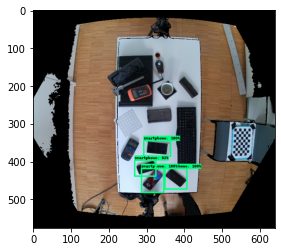

In [16]:
import os
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# file with class lables 
class_labels = os.path.join('annotations', 'annotations.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(class_labels)

# test images
test_image_1 = os.path.join('resources/images/test/5_scene.png')
test_image_2 = os.path.join('resources/images/test/10_scene.png')
test_image_3 = os.path.join('resources/images/test/15_scene.png')
test_image_4 = os.path.join('resources/images/test/20_scene.png')
test_image_5 = os.path.join('resources/images/test/25_scene.png')

img = cv2.imread(test_image_1)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

### 6.3 Detect objects in real time using webcam

In [17]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break